# Introduction to pytket

In [1]:
# configure some visualisations

from pytket.circuit.display import get_circuit_renderer

circuit_renderer = get_circuit_renderer()

circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()

## Bell and GHZ states

As a basic intro, lets build a circuit to prepare the bell state.

In pytket we can create an instance of the `Circuit` class and add gates sequentially. We can prepare an entangled Bell state using a Hadamard and a CX gate

$$
\begin{equation}
\text{H} = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}\,, 
\quad
\text{CX} = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
\end{equation}
$$

In [2]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter as draw

bell_circ = Circuit(2).H(0).CX(0, 1)
draw(bell_circ)

For small circuits we can get the statevector directly

In [3]:
print(bell_circ.get_statevector())

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [4]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()

# Add some measurements to bell_circ
bell_circ.measure_all()

[H q[0]; CX q[0], q[1]; Measure q[0] --> c[0]; Measure q[1] --> c[1]; ]

In [5]:
result = backend.run_circuit(bell_circ, n_shots=1000)

In [6]:
print(result.get_counts())

Counter({(1, 1): 506, (0, 0): 494})


We can also build a more general circuit to prepare the GHZ state 

$$
|\psi\rangle_{\text{GHZ}} = \frac{1}{\sqrt{2}}\big(|0\rangle^{\otimes n} + |1\rangle^{\otimes n}\big)
$$

 by defining a function which builds a circuit given an integer number of qubits.

In [7]:
def prepare_ghz(n_qubits: int) -> Circuit:
    ghz_circ = Circuit(n_qubits)
    ghz_circ.H(0)

    for index in range(n_qubits - 1):
        ghz_circ.CX(index, index + 1)

    return ghz_circ

In [8]:
draw(prepare_ghz(4))

In [9]:
from pytket.extensions.qiskit import AerStateBackend

sv_backend = AerStateBackend()

ghz_state = prepare_ghz(n_qubits=5)

result = sv_backend.run_circuit(ghz_state)
statevector = result.get_state()


print("Statevector dimensions: ", statevector.shape)
print("GHZ Statevector: ", statevector)

Statevector dimensions:  (32,)
GHZ Statevector:  [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


## Quantum Fourier transform 

As we've heard the Quantum Fourier Transform (QFT) is an important subroutine in several quantum algorithms including Shor's algorithm for factoring.


We can build the circuit for the $n$ qubit QFT using $n$ Hadamard gates $\frac{n}{2}$ swap gates and $\frac{n(n-1)}{2}$ controlled unitary rotations. 

$$
\begin{equation}
\text{CU1} = 
\begin{pmatrix}
I & 0 \\
0 & \text{U1}
\end{pmatrix}
\,, \quad 
\text{U1} = 
\begin{pmatrix}
1 & 0 \\
0 & e^{i \pi \theta}
\end{pmatrix}
\end{equation}
$$

Note that in the code below we use the `OpType` enum to access the CU1 gate.

We will rotate by smaller and smaller angles of $\theta = \frac{1}{2^{n-1}}$ 





In [10]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="$$QFT$$")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ


In [11]:
draw(build_qft_circuit(3))

In [12]:
from pytket.circuit import CircBox

qft4_circ = build_qft_circuit(4)

qft4_box: CircBox = CircBox(qft4_circ)
qft_circ = Circuit(4).add_gate(qft4_box, [0, 1, 2, 3])
draw(qft_circ)

In [13]:
inv_qft4_box = qft4_box.dagger
# Explicitly set the name of the `CircBox` to $$QFT^\dagger$$
inv_qft4_box.circuit_name = "$$QFT^\dagger$$"
qft_inv_circ = Circuit(4)
qft_inv_circ.add_gate(inv_qft4_box, [0, 1, 2, 3])
draw(qft_inv_circ)

## Going between qiskit <-> pytket and qasm <-> pytket



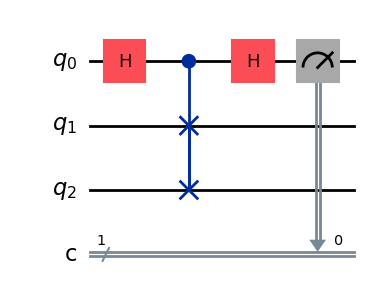

In [14]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3, 1)
qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.measure(0, 0)
qc.draw("mpl")

In [17]:
from pytket.extensions.qiskit import qiskit_to_tk


tkc = qiskit_to_tk(qc)
draw(tkc)

In [15]:
from pytket.qasm import circuit_from_qasm

qpe_circ = circuit_from_qasm("qasm/qpe_circ_2_5.qasm")
print("Total number of gates =", qpe_circ.n_gates)
print("#two qubit gates =", qpe_circ.n_2qb_gates())

draw(qpe_circ)

Total number of gates = 292
#two qubit gates = 98


## Pauli exponentials

A common task in quantum computing is generating a unitary circuit to implement an operator $U=e^{i \theta P}$. Where $P$ is a Hermetian matrix.

In quantum computing we frequently see expressions involving the matrix exponential


$$
e^A = \sum_{k=0}^\infty \frac{A^k}{k!}
$$

Example (Note $X = H \, Z\, H$)

$$
\mathrm{Rx}(t) = e^{-\frac{1}{2}i \pi \alpha X} =  H e^{-\frac{1}{2}i \pi \alpha Z} H = 
\begin{pmatrix} \cos\frac{\pi\alpha}{2} & -\sin\frac{\pi\alpha}{2}
    \\ \sin\frac{\pi\alpha}{2} & \cos\frac{\pi\alpha}{2} \end{pmatrix} 
$$

By using the series definition of matrix exponential it is possible to show that any such operator $U$ can be written as 

$$
U = e^{i \theta P} = e^{i \theta V D V^\dagger} = V e^{i\theta D} V^\dagger
$$




Consider the diagonal operator $U_{ZZZZ} = e^{i\theta \big( Z \otimes Z \otimes Z \otimes Z \big)}$. It turns out this can be implemented with the following circuit.




![](images/pauli_exp4.png "Pauli exp circuit"){align=center}


$$
|x\rangle \mapsto \begin{cases} e^{-i \alpha t} |x\rangle \, \,\,\text{if} \,\,\, \sum_i x_i \,\,\, \text{is even} \\ e^{i \alpha t} |x\rangle \, \text{if} \, \sum_i x_i \, \text{is odd}  \end{cases}
$$





In [31]:
from pytket.circuit import PauliExpBox
from pytket.pauli import Pauli

# Construct a PauliExpBox with a list of Paulis followed by the phase theta
zzzz = PauliExpBox([Pauli.Z, Pauli.Z, Pauli.Z, Pauli.Z], -0.2)

pauli_circ = Circuit(4)

pauli_circ.add_gate(zzzz, [0, 1, 2, 3])
draw(pauli_circ)

In [33]:
from pytket.passes import DecomposeBoxes

DecomposeBoxes().apply(pauli_circ)
draw(pauli_circ)

In [36]:
xyzz = PauliExpBox([Pauli.X, Pauli.Y, Pauli.Z, Pauli.Z], -0.2)

pauli_circ = Circuit(4)

pauli_circ.add_gate(xyzz, [0, 1, 2, 3])
draw(pauli_circ)

In [37]:
DecomposeBoxes().apply(pauli_circ)
draw(pauli_circ)

## Brief overview of circuit transformations


### Convert a circuit to another gateset



In [27]:
jw_chem_circ = circuit_from_qasm("qasm/H2JordanWignerMapper.qasm")
draw(jw_chem_circ)

print("Total gate count =", jw_chem_circ.n_gates)
print("#2 qubit gates =", jw_chem_circ.n_2qb_gates())

Total gate count = 150
#2 qubit gates = 56


In [28]:
from pytket.passes import AutoRebase
from pytket.circuit import OpType

rebase = AutoRebase({OpType.CX, OpType.Rx, OpType.Rz})


rebase.apply(jw_chem_circ)
draw(jw_chem_circ)
print("Total gate count =", jw_chem_circ.n_gates)
print("#2 qubit gates =", jw_chem_circ.n_2qb_gates())


Total gate count = 230
#2 qubit gates = 56


In [29]:
from pytket.passes import GreedyPauliSimp

GreedyPauliSimp().apply(jw_chem_circ)

draw(jw_chem_circ)
print("Total gate count =", jw_chem_circ.n_gates)
print("#2 qubit gates =", jw_chem_circ.n_2qb_gates())

Total gate count = 37
#2 qubit gates = 14
